In [ ]:
!pip install scikit-learn pandas numpy matplotlib seaborn joblib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving expenses.csv to expenses.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['expenses.csv']))

In [ ]:
df.head()

,date,time,amount,category,subcategory,description,payment_method,merchant,location,is_weekend,is_month_end,day_of_week,month,is_essential
0,2025-07-28,13:09:53,17186.67,Healthcare,Doctor,Doctor - Medicine,UPI,Apollo,Restaurant,0,1,0,7,1
1,2025-08-21,13:09:53,18355.50,Bills,Internet,Internet bill for August,UPI,Swiggy,Home,0,0,3,8,1
2,2025-12-02,13:09:53,5841.14,Entertainment,Concerts,Concerts: Movie ticket,UPI,Starbucks,Work,0,0,1,12,0
3,2025-08-27,13:09:53,3566.22,Bills,Internet,Internet bill for August,Cash,Shell,Home,0,1,2,8,1
4,2025-08-10,13:09:53,18423.62,Healthcare,Medicine,Medicine - Medicine,Credit Card,Starbucks,Online,1,0,6,8,1


In [ ]:
print(f"Dataset shape: {df.shape}")
print("\nColumns:", df.columns.tolist())

Dataset shape: (1000, 14)

Columns: ['date', 'time', 'amount', 'category', 'subcategory', 'description', 'payment_method', 'merchant', 'location', 'is_weekend', 'is_month_end', 'day_of_week', 'month', 'is_essential']


In [ ]:
#EDA
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Bills'),
  Text(1, 0, 'Food'),
  Text(2, 0, 'Entertainment'),
  Text(3, 0, 'Transport'),
  Text(4, 0, 'Healthcare'),
  Text(5, 0, 'Shopping')])

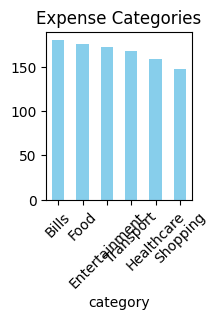

In [ ]:
plt.subplot(2, 3, 1)
df['category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Expense Categories')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Amount Distribution by Category')

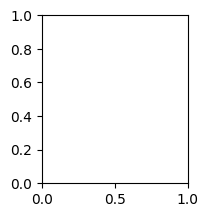

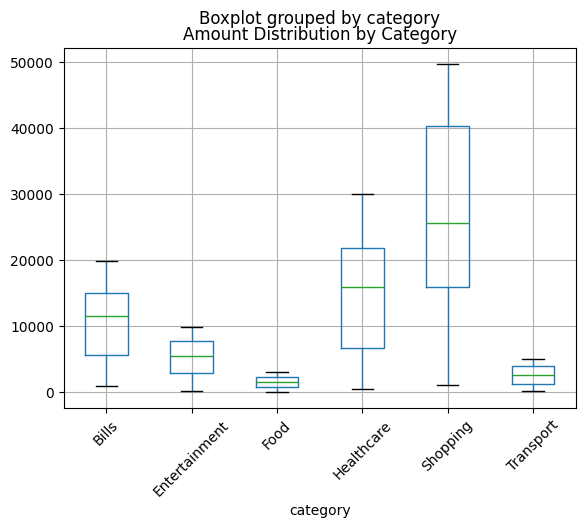

In [ ]:
plt.subplot(2, 3, 2)
df.boxplot(column='amount', by='category', rot=45)
plt.title('Amount Distribution by Category')

Text(0.5, 1.0, 'Essential vs Non-essential Expenses')

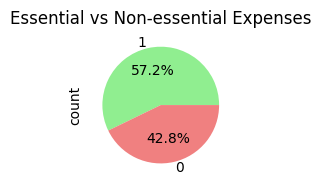

In [ ]:
plt.subplot(2, 3, 3)
df['is_essential'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Essential vs Non-essential Expenses')

([<matplotlib.axis.XTick at 0x7abf00cb6600>,
 [Text(0, 0, 'Weekday'), Text(1, 0, 'Weekend')])

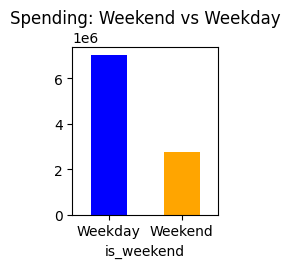

In [ ]:
plt.subplot(2, 3, 4)
weekend_data = df.groupby('is_weekend')['amount'].sum()
weekend_data.plot(kind='bar', color=['blue', 'orange'])
plt.title('Spending: Weekend vs Weekday')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)

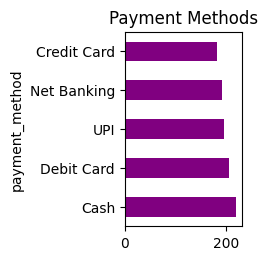

In [ ]:
plt.subplot(2, 3, 5)
df['payment_method'].value_counts().plot(kind='barh', color='purple')
plt.title('Payment Methods')

plt.tight_layout()
plt.show()

In [ ]:
# Feature Engineering
df['amount'].quantile(0.25)

np.float64(2100.69)

In [ ]:
# Create new features
df['date'] = pd.to_datetime(df['date'])
df['day_of_month'] = df['date'].dt.day
df['is_large_expense'] = (df['amount'] > df['amount'].quantile(0.75)).astype(int)
df['amount_log'] = np.log1p(df['amount'])  # For normalization

In [ ]:
df = df.sort_values('date')
df['avg_spend_last_7_days'] = df.groupby('category')['amount'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

In [ ]:
df.head()

,date,time,amount,category,subcategory,description,payment_method,merchant,location,is_weekend,is_month_end,day_of_week,month,is_essential,day_of_month,is_large_expense,amount_log,avg_spend_last_7_days
332,2025-07-05,13:09:53,338.97,Transport,Public Transport,Public Transport - Long trip,Net Banking,Shell,Online,1,0,5,7,1,5,0,5.828857,338.970
717,2025-07-05,13:09:53,1740.87,Food,Snacks,Snacks at Zomato,Net Banking,Swiggy,Work,1,0,5,7,0,5,0,7.462715,1740.870
454,2025-07-05,13:09:53,1231.22,Food,Restaurant,Restaurant at Zomato,UPI,Apollo,Restaurant,1,0,5,7,1,5,0,7.116573,1486.045
937,2025-07-06,13:09:53,22569.76,Healthcare,Insurance,Insurance - Regular checkup,Cash,Netflix,Home,1,0,6,7,1,6,1,10.024411,22569.760
875,2025-07-06,13:09:53,14839.34,Bills,Internet,Internet bill for July,Cash,Apollo,Hospital,1,0,6,7,1,6,1,9.605104,14839.340


In [ ]:
# Preparing features and target
# Features to use
categorical_features = ['category', 'subcategory', 'payment_method', 'merchant', 'location']
numerical_features = ['amount', 'is_weekend', 'is_month_end', 'day_of_week',
                      'month', 'day_of_month', 'is_large_expense']

# Select features
X = df[categorical_features + numerical_features].copy()
y = df['is_essential']

print(f"Features: {X.shape[1]}")
print(f"Target distribution:\n{y.value_counts()}")

Features: 12
Target distribution:
is_essential
1    572
0    428
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Train model
pipeline.fit(X_train, y_train)


Training set: (800, 12)
Test set: (200, 12)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amount', 'is_weekend',
                                                   'is_month_end',
                                                   'day_of_week', 'month',
                                                   'day_of_month',
                                                   'is_large_expense']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['category', 'subcategory',
                                                   'payment_method', 'merchant',
                                                   'location'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [ ]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-essential', 'Essential']))

Accuracy: 74.00%

Classification Report:
               precision    recall  f1-score   support

Non-essential       0.69      0.71      0.70        86
    Essential       0.78      0.76      0.77       114

     accuracy                           0.74       200
    macro avg       0.73      0.74      0.74       200
 weighted avg       0.74      0.74      0.74       200



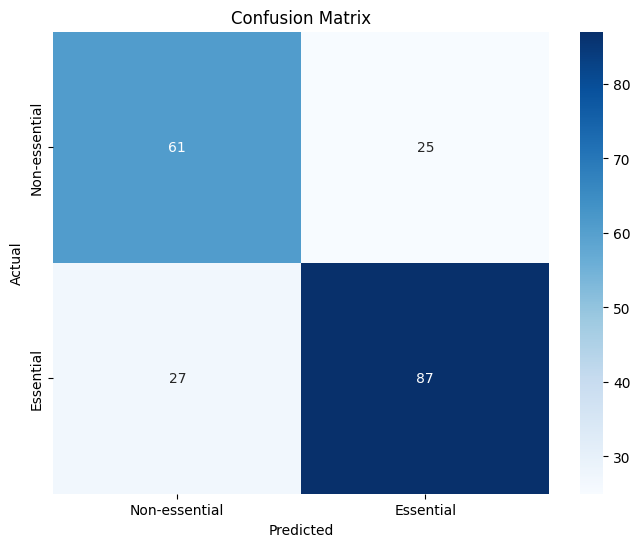

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-essential', 'Essential'],
            yticklabels=['Non-essential', 'Essential'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Feature Importance

# Get feature names after one-hot encoding
preprocessor.fit(X_train)
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'cat':
        ohe = trans.named_steps['onehot']
        cat_features = ohe.get_feature_names_out(cols)
        feature_names.extend(cat_features)

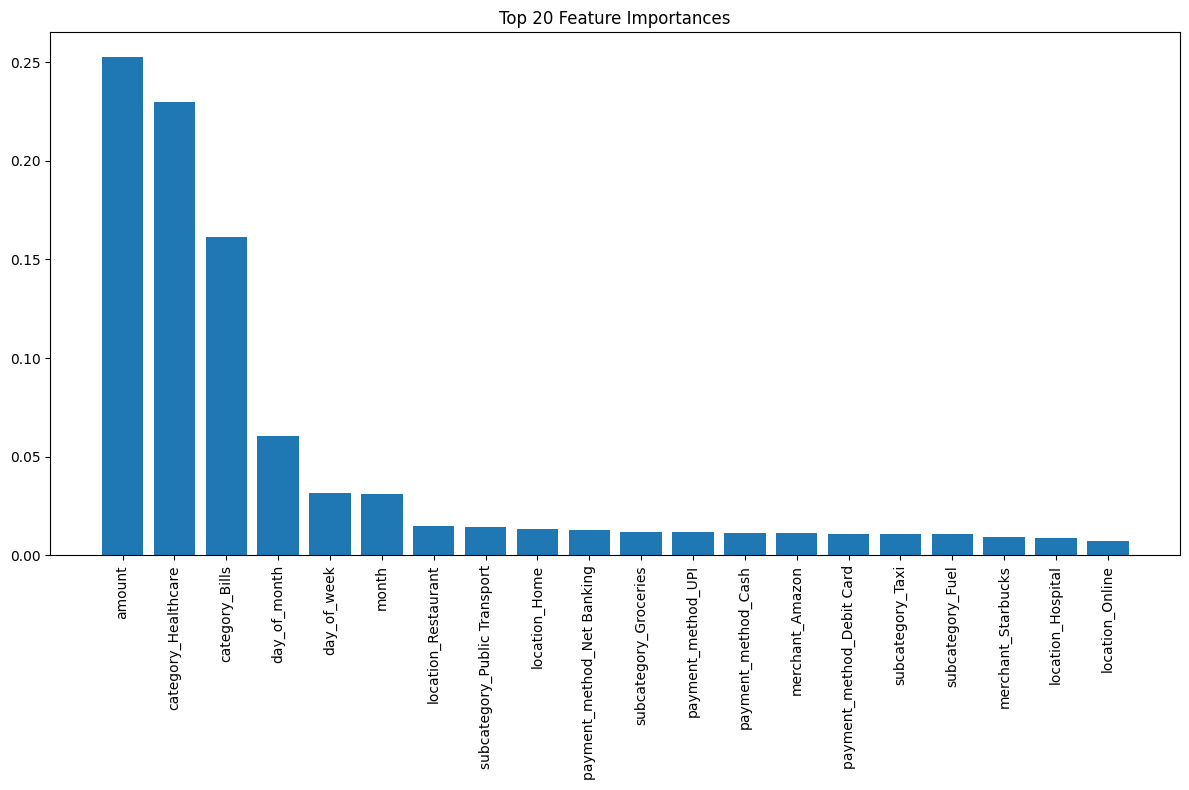

In [ ]:
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
top_n = min(20, len(feature_names))
plt.title(f"Top {top_n} Feature Importances")
bars = plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
plt.tight_layout()
plt.show()

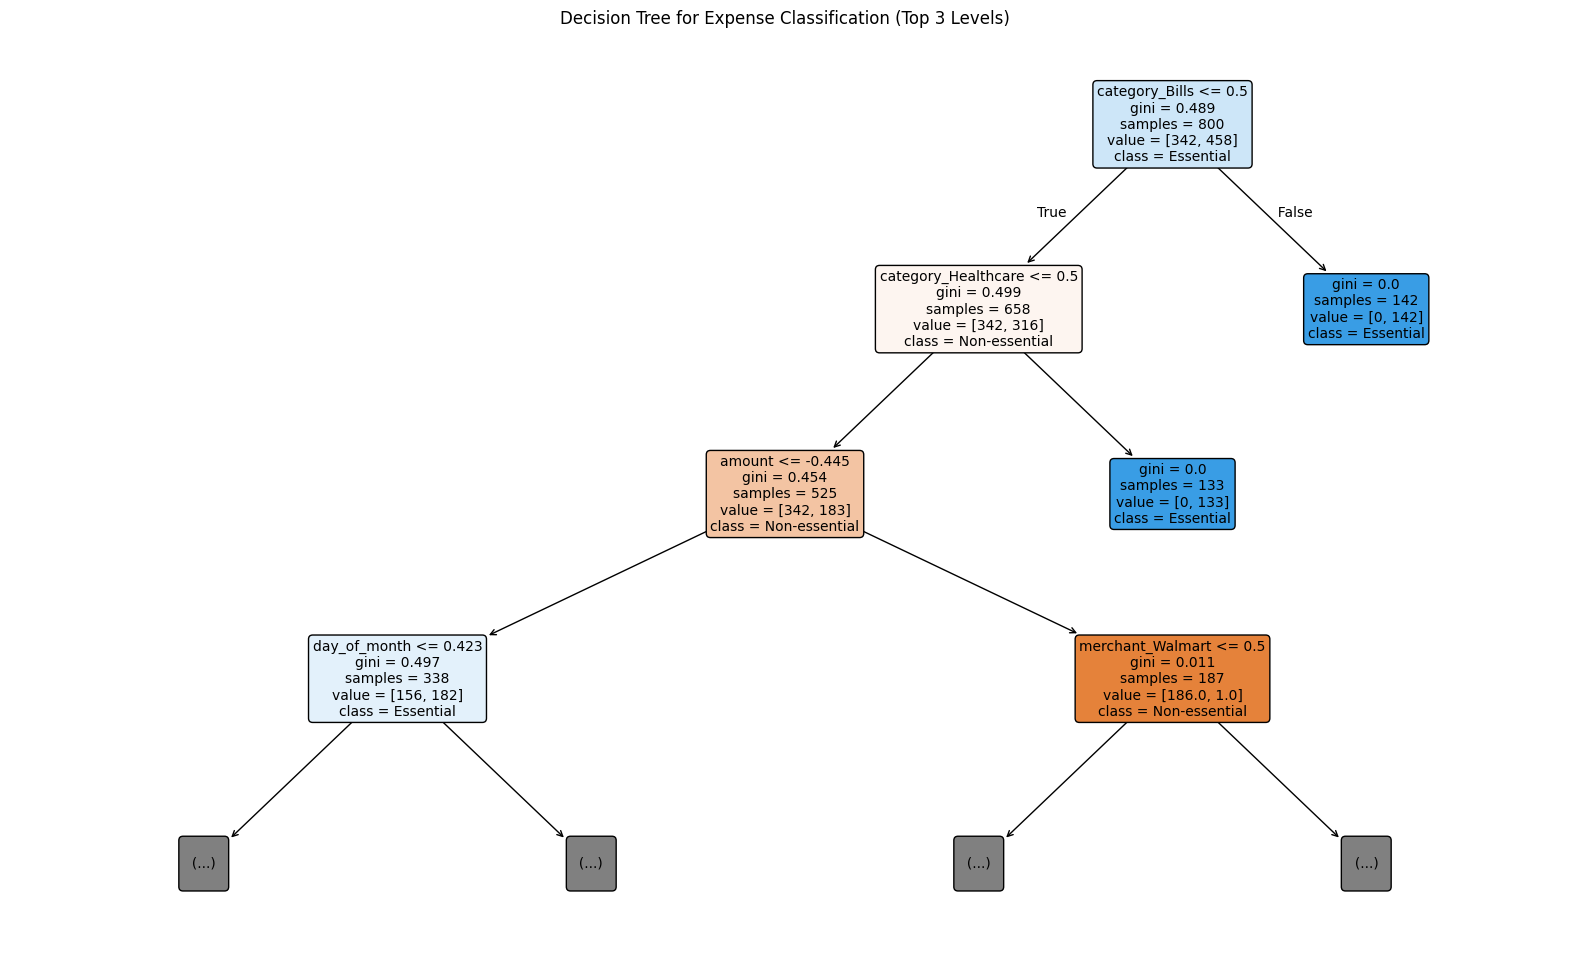

In [ ]:
# Visualizing Decision Trees

plt.figure(figsize=(20, 12))
plot_tree(pipeline.named_steps['classifier'],
          feature_names=feature_names,
          class_names=['Non-essential', 'Essential'],
          filled=True,
          rounded=True,
          max_depth=3,  # Show only top 3 levels
          fontsize=10)
plt.title("Decision Tree for Expense Classification (Top 3 Levels)")
plt.show()

In [ ]:
# Hyperparameter Tuning

param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.2%}")

# Use best model
best_model = grid_search.best_estimator_

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best CV score: 85.05%


In [ ]:
print(best_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amount', 'is_weekend',
                                                   'is_month_end',
                                                   'day_of_week', 'month',
                                                   'day_of_month',
                                                   'is_large_expense']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple

In [ ]:
joblib.dump(best_model, 'expense_classifier_pipeline.pkl')

joblib.dump(preprocessor, 'expense_preprocessor.pkl')
joblib.dump(grid_search.best_estimator_.named_steps['classifier'],
           'expense_decision_tree.pkl')

['expense_decision_tree.pkl']